In [1]:
%matplotlib notebook
# ----
%matplotlib notebook
# ----
%matplotlib inline


In [2]:
get_ipython().run_line_magic('matplotlib', 'notebook')


# imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.widgets import Slider
import time
import os

class Player():
    def __init__(self,shape,brain):
        # physics variables
        self.a_y = -100
        self.v_y = 20
        self.y = 50
        self.x = 30
        self.jump_x = 20
        self.alive = True
        # nural network creation
        # weights
        self.shape = shape
        self.brain = brain
        # layers
        self.layers = []
        for i in range(len(shape)):
            self.layers.append(np.ones(self.shape[i]))

    def randomizeBrain(self):
        self.brain = []
        for i in range(len(self.shape)-1):
            self.brain.append((np.random.rand(self.shape[i+1],self.shape[i])*2)-1)

    def act(self,p_b,p_t,p_d):
        self.in_vec = np.array([p_b,p_t,p_d,self.y,self.v_y])
        #self.in_vec /= 10
        self.layers[0] = self.in_vec
        for i, w in enumerate(self.brain):
            self.layers[i+1] = np.dot(self.layers[i],w.T)

            self.layers[i+1] = np.tanh(self.layers[i+1])
            #self.layers[i+1] = 1 / (1 + np.exp(self.layers[i+1]))
        if self.layers[-1][0] > 0.5:
            if self.x - self.jump_x >= 10:
                self.v_y = 40
                self.jump_x = self.x

    def isDead(self,p_b,p_t,p_d):
        if self.alive == False:
            return
        if self.alive:
            if self.y >= 94 or self.y <= 0:
                self.a_y = 0
                self.v_y = 0
                self.alive = False
            elif p_d < 0:
                self.alive = True
            elif p_d < 17:
                if self.y+5 >= p_t or self.y <= p_b:
                    self.a_y = 0
                    self.v_y = 0
                    self.alive = False
            else:
                self.alive = True

    def mutate(self,rate,n,mc):
        mutants = []
        for i in range(n):
            if np.random.choice(np.array([True,False]),p=[mc,1-mc]):
                new_brain = []
                for j in range(len(self.shape)-1):
                    new_brain.append(self.brain[j] + (np.random.rand(self.shape[j+1],self.shape[j])*rate) - rate/2)
                mutants.append(Player(self.shape,new_brain))
            else:
                mutants.append(Player(self.shape,self.brain))
        return mutants

class Game():
    def __init__(self, N, shape, lr, rp, mc, gpr):
        self.birds = []
        self.players = []
        self.N = N
        self.shape = shape
        self.lr = lr
        self.rp = rp
        self.mc = mc
        self.gpr = gpr
        plt.show()
        self.game()

    def birdDrawFirst(self, x, y, image, ax=None, zoom=1):
        for x0, y0 in np.array([x,y]).T[:10]:
            self.birds.append(ax.imshow(image, interpolation='nearest', extent=[x0,x0+(17*zoom),y0,y0+(12*zoom)]))

    def birdMove(self, x, y, image, ax, zoom=1):
        for i in self.birds:
            ax.images.remove(i)

        for i, (x0, y0) in enumerate(zip(x,y)):
            if i >= 10:
                break
            self.birds[i] = ax.imshow(image, interpolation='nearest', extent=[x0,x0+(17*zoom),y0,y0+(12*zoom)])

    def game(self):
        tps = 50
        self.players = []
        for i in range(self.N):
            p = Player(self.shape,np.zeros(self.shape))
            p.randomizeBrain()
            self.players.append(p)
        self.players = np.array(self.players)

        fig = plt.figure(figsize=(8,7))

        ax = fig.add_axes([0,.1,.4,.9])
        nn = fig.add_axes([.5,.15,.4,.8])
        gen = 0
        bg_img = plt.imread(r'images/bg.png')
        while True:
            gen += 1
            # physics variables
            t = 1/tps
            self.last_x_birds = np.empty((self.gpr, self.N))
            for g in range(self.gpr):
                ax.clear()
                self.bg = ax.imshow(bg_img, interpolation='none', extent=[0,56.25,100,0])
                ax.set_ylim(0,100)
                self.birds = []
                birds_x = np.full(self.N,30)
                birds_y = np.full(self.N,50)
                birds_img = plt.imread(os.path.abspath(r'images/bird.png'))
                self.birdDrawFirst(birds_x,birds_y,birds_img,ax=ax,zoom=0.5)
                p_x = 0
                p_t = np.random.rand()*60 + 30
                p_b = p_t - 20
                p_t_img = plt.imread(os.path.abspath(r'images/pt.png'))
                p_b_img = plt.imread(os.path.abspath(r'images/pb.png'))
                p_t_img = plt.imread(os.path.abspath(r'images/pt.png'))
                p_b_img = plt.imread(os.path.abspath(r'images/pb.png'))
                self.p_b_s = ax.imshow(p_b_img, extent = [p_x-10, p_x, p_b-100, p_b])
                self.p_t_s = ax.imshow(p_t_img, extent = [p_x-10, p_x, p_t, p_t+100])
                ax.set_title("generation: " + str(gen))
                p_t_coords = [p_t]
                x = 0
                while True:
                    #v_x += 0.01
                    p_x += 80
                    p_t = np.random.rand()*40 + 30
                    p_t_coords.append(p_t)
                    p_b = p_t - 20
                    self.p_b_s.set_extent([p_x-10, p_x, p_b-100, p_b])
                    self.p_t_s.set_extent([p_x-10, p_x, p_t, p_t+100])
                    for j in range(20):
                        for i in range(4):
                            for ind, p in enumerate(self.players):
                                p.isDead(p_b,p_t,p_x-p.x)
                                if p.alive:
                                    p.x += 1
                                    p.v_y += p.a_y*t
                                    p.y += p.v_y*t + p.a_y*t**2
                                    p.act(p.y-p_b,p.y-p_t,p_x-p.x)
                                    birds_x[ind] = p.x
                                    birds_y[ind] = p.y

                        x = np.max(birds_x) - 30
                        ax.set_xlim(x,x+60)
                        self.bg.set_extent([x,x+60,0,100])
                        self.players_sorted = self.players[np.flip(np.argsort(birds_x))]
                        birds_y_sorted = birds_y[np.flip(np.argsort(birds_x))]
                        birds_x_sorted = birds_x[np.flip(np.argsort(birds_x))]
                        self.birdMove(birds_x_sorted, birds_y_sorted, birds_img, ax, zoom=0.5)
                        fig.canvas.draw()
                        time.sleep(t)
                    for ind, p in enumerate(self.players):
                        if p.alive:
                            break
                    else:
                        self.last_x_birds[g] = birds_x
                        new_players = []
                        for p in self.players:
                            new_players.append(Player(p.shape,p.brain))
                        self.players = np.array(new_players)
                        break
            last_x_avg = np.average(self.last_x_birds,axis=0)
            best = self.players[np.argsort(last_x_avg)[-1]]
            nn.clear()
            nn.set_xlim(-0.2,0.9)
            nn.set_ylim(0,1.8)

            diff = 1.6 / np.array(self.shape).max()
            coords = []
            layers = []
            segs = []
            widths = []
            colors = []
            for i,l in enumerate(self.shape):
                layer = []
                for j in range(l):
                    h = diff*j
                    layer.append([1/len(self.shape)*i,h+(2-diff*l)/2])
                    coords.append([1/len(self.shape)*i,h+(2-diff*l)/2])

                layers.append(layer)
            coords = np.array(coords)
            for i in range(len(self.shape)-1):
                 for j, n in enumerate(layers[i+1]):
                        for k, c in enumerate(layers[i]):
                            segs.append([c,n])
                            widths.append(abs(np.array(best.brain[i])[j,k]))
                            if np.array(best.brain[i])[j,k] > 0:
                                colors.append([0,0.2,1])
                            else:
                                colors.append([1,0.2,0])
            lc = LineCollection(segs,linewidths=widths,colors=colors)
            nn.add_collection(lc)
            nn.scatter(coords[:,0],coords[:,1],s=100,c="w",edgecolors="black",zorder=1000)
            nn.set_title("best neural network")

            parents = self.players[np.argsort(last_x_avg)[-int(self.N/(100/self.rp)):]]
            next_gen = np.array([])
            for p in parents:
                next_gen = np.hstack((next_gen, np.array(p.mutate(self.lr,int(100/self.rp), self.mc))))
            self.players = next_gen


<IPython.core.display.Javascript object>


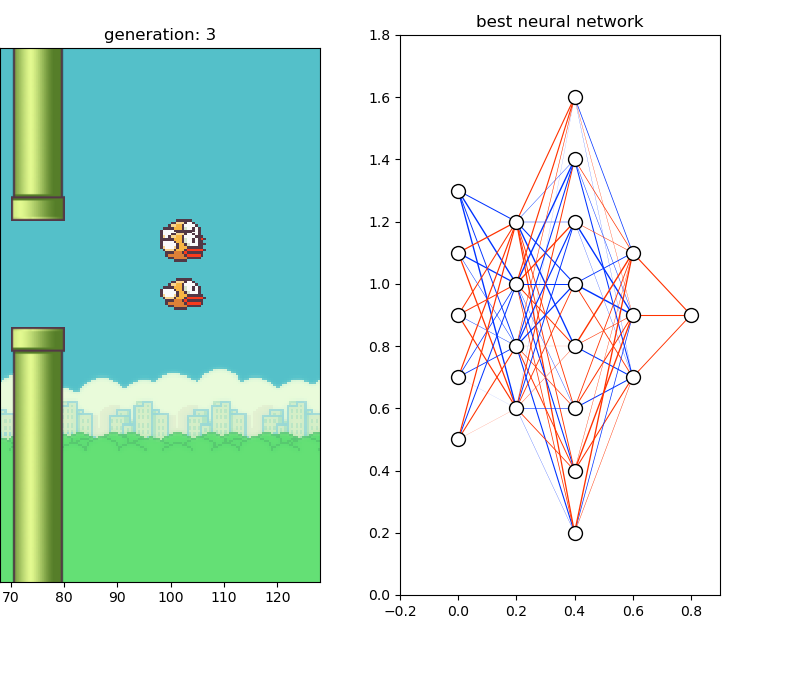

KeyboardInterrupt: 

In [47]:
N = 20  # number of players  

shape = [5,4,8,3,1] # shape of neral network. firs value must be 5. last value must be 1

reproduction_precentage = 5 # precentage of players who get rproduced

learning_rate = 0.1 # rate in which the ai learns

mutatuion_chance = 0.6 # chance that reproduction will result in mutation

games_per_generation = 1 # games per generation
# ---------------------------------------------------------------------------------------------------------

plt.show()
Game(N, shape, learning_rate, reproduction_precentage, mutatuion_chance, games_per_generation)

<IPython.core.display.Javascript object>


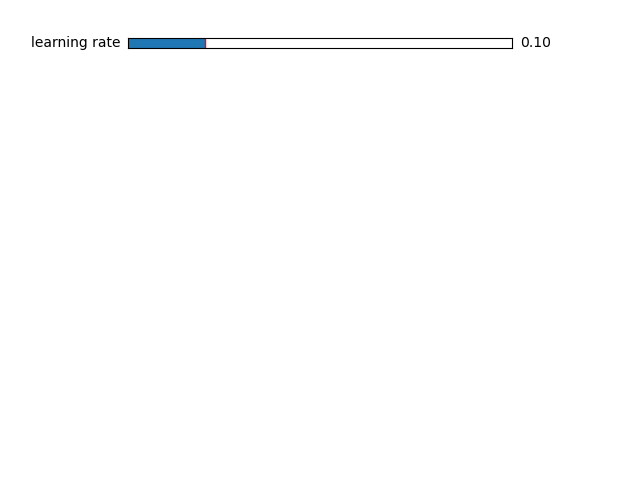

In [7]:
fig = plt.figure()

lr_ax = fig.add_axes([.2,.9,.6,.02])
lr_sl = Slider(lr_ax, 'learning rate', .05, .3, valinit=.1, valstep=.01)
lr_sl.active = False

sp_ax = fig.add_axes([])
